In [61]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

players = pd.read_csv('./Dataset/players.csv')
teams = pd.read_csv('./Dataset/teams.csv')
players_teams = pd.read_csv('./Dataset/players_teams.csv')
awards_players = pd.read_csv('./Dataset/awards_players.csv')
coaches = pd.read_csv('./Dataset/coaches.csv')
series_post = pd.read_csv('./Dataset/series_post.csv')
teams_post = pd.read_csv('./Dataset/teams_post.csv')



### Awards_players


- corrected name of a prize
- drop lgID
- calculate the number of prizes that each player has (having in consideration the year)
- drop award (name)

In [62]:
awards_players['award'] = awards_players['award'].replace("Kim Perrot Sportsmanship", "Kim Perrot Sportsmanship Award")
awards_players = awards_players.drop(columns=['lgID'], axis=1)

# Sort the DataFrame by playerID and year
awards_players.sort_values(by=["playerID", "year"], inplace=True)

awards_players['num_prizes'] = awards_players.groupby('playerID').cumcount() + 1

awards_players = awards_players.drop(columns=['award'], axis=1)


### Players

- drop college, collegeOther, pos and lastseason
- remove who has height = 0
- replace height error (9) with the average
- replace weight error (0) with the average


In [63]:
players = players.drop('college', axis=1)
players = players.drop('pos', axis=1)
players = players.drop('collegeOther', axis=1)
# Have only 0s
players = players.drop('lastseason', axis=1)
players = players.drop('firstseason', axis=1)

players = players[players['height'] > 0]

# Calculate the mean of non-zero heights
mean_height = players[(players['height'] != 0) | (players['height'] != 9)]['height'].mean()
# Replace 9 with the mean height
players['height'] = players['height'].replace(9, mean_height)

# Calculate the mean of non-zero weights
mean_weight = players[players['weight'] != 0]['weight'].mean()
players['weight'] = players['weight'].replace(0, mean_weight)



- add a column called Age, considering the year of the season. Calculated through the merge between two datasets
- drop birthdate and deathdate


In [64]:
def calculate_age(row):
    birth_year = int(row['birthDate'][:4])
    age = 2000 + row['year'] - birth_year
    return age

players_teams = players_teams.drop('lgID', axis=1)

merged_data = players.merge(players_teams, left_on='bioID', right_on='playerID')

merged_data = merged_data.merge(awards_players, left_on=['bioID', 'year'], right_on=['playerID', 'year'], how='left')
merged_data.sort_values(by=["bioID", "year"], inplace=True)

merged_data['num_prizes'] = merged_data.groupby('bioID')['num_prizes'].ffill()

# Fill NaN values with 0 for players with no prizes 
merged_data['num_prizes'].fillna(0, inplace=True)

# Apply the function to each row
merged_data['age'] = merged_data.apply(calculate_age, axis=1)

merged_data = merged_data.drop('birthDate', axis=1)
merged_data = merged_data.drop('deathDate', axis=1)
merged_data = merged_data.drop('playerID_x', axis=1)
merged_data = merged_data.drop('playerID_y', axis=1)





### Coaches

- drop lgID, stint, post_wins and post_losses
- create column num_prizes (merging awards_players)

In [65]:
coaches = coaches.drop(columns=['lgID'], axis=1)
coaches = coaches.drop(columns=['stint'], axis=1)
coaches = coaches.drop(columns=['post_wins'], axis=1)
coaches = coaches.drop(columns=['post_losses'], axis=1)

coaches = coaches.merge(awards_players, left_on=['coachID', 'year'], right_on=['playerID', 'year'], how='left')
coaches.sort_values(by=["coachID", "year"], inplace=True)

coaches['num_prizes'] = coaches.groupby('coachID')['num_prizes'].ffill()

# Fill NaN values with 0 for players with no prizes 
coaches['num_prizes'].fillna(0, inplace=True)

coaches = coaches.drop(columns=['playerID'], axis=1)


### Teams

- drop seeded, confID, divID, franchID, arena, lgID and name
- corrected error: one season it was registered two winners

In [66]:

teams = teams.drop(columns=['seeded'], axis=1)
teams = teams.drop(columns=['confID'], axis=1)
teams = teams.drop(columns=['divID'], axis=1)
teams = teams.drop(columns=['franchID'], axis=1)
teams = teams.drop(columns=['arena'], axis=1)
teams = teams.drop(columns=['lgID'], axis=1)
teams = teams.drop(columns=['name'], axis=1)
teams = teams.drop(columns=['tmORB'], axis=1)
teams = teams.drop(columns=['tmDRB'], axis=1)
teams = teams.drop(columns=['tmTRB'], axis=1)
teams = teams.drop(columns=['opptmORB'], axis=1)
teams = teams.drop(columns=['opptmDRB'], axis=1)
teams = teams.drop(columns=['opptmTRB'], axis=1)


# In the year 6, a victory was incorrectly recorded.
teams.loc[(teams['year'] == 6) & (teams['tmID'] == 'CON'), 'finals'] = 'L'



- calculate the number of prizes a team has (total of prizes the players have), creating the column num_prizese

In [67]:

playerAndTeams = merged_data.merge(teams, on=["tmID", "year"])

# Filter for teams that won the finals
winners_data = playerAndTeams[playerAndTeams['finals'] == 'W']

# Group by team and year, summing the number of prizes
team_prizes = playerAndTeams.groupby(['tmID', 'year'])['num_prizes'].sum().reset_index()

# Sort the result by year
team_prizes.sort_values(by='year', ascending=True, inplace=True)
print(team_prizes)

teams = teams.merge(team_prizes, on=["tmID", "year"])


    tmID  year  num_prizes
63   MIA     1         0.0
24   DET     1         0.0
89   PHO     1         0.0
129  UTA     1         0.0
99   POR     1         0.0
..   ...   ...         ...
75   MIN    10         3.0
85   NYL    10         1.0
98   PHO    10        10.0
52   IND    10        10.0
141  WAS    10         1.0

[142 rows x 3 columns]


- add to the table teams the number of prizes the coach has (sum it in the column num_prizes)

In [68]:
""" teams = pd.merge(teams, coaches[['tmID', 'year', 'won', 'lost']], on=['tmID', 'year'], how='left')

teams = teams.rename(columns={'won_y': 'coach_won', 'lost_y': 'coach_lost'})

print(teams) """

merged_df = pd.merge(teams, coaches, on=['year', 'tmID'], how='left')

merged_df['num_prizes_y'] = merged_df['num_prizes_y'].fillna(0)

merged_df['num_prizes'] = merged_df['num_prizes_x'] + merged_df['num_prizes_y']

merged_df = merged_df.drop(['num_prizes_x', 'num_prizes_y'], axis=1)

# Update the 'num_prizes' column in the original teams DataFrame
teams['num_prizes'] = merged_df['num_prizes']

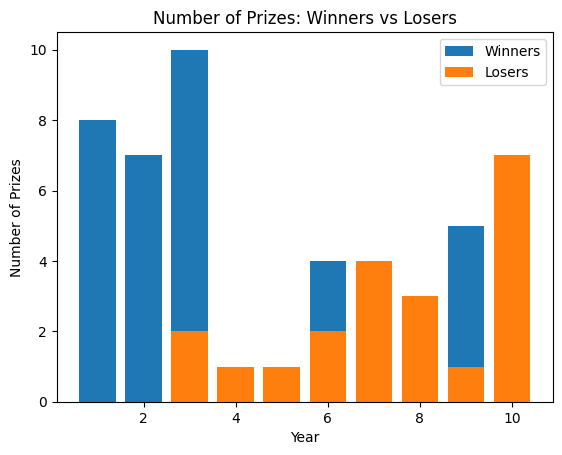

In [69]:
winners = teams[teams['finals'] == 'W']
losers = teams[teams['finals'] == 'L']

# Plotting
plt.bar(winners['year'], winners['num_prizes'], label='Winners')
plt.bar(losers['year'], losers['num_prizes'], label='Losers')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Number of Prizes')
plt.title('Number of Prizes: Winners vs Losers')
plt.legend()

# Show the plot
plt.show()



In [70]:
teams.to_csv('./Modified/modified_teams.csv', index=False)
players.to_csv('./Modified/modified_players.csv', index=False)
awards_players.to_csv('./Modified/modified_awards.csv', index=False)
merged_data.to_csv('./Modified/players_playersTeams.csv', index=False)
coaches.to_csv('./Modified/modified_coaches.csv', index=False)